# Probabilistic iLQR 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import dot
from numpy.linalg import inv
from IPython.display import clear_output
import time
from scipy.stats import multivariate_normal as mvn
from ocp import *
import pdb
%load_ext autoreload
%autoreload 2

np.set_printoptions(precision=4, suppress=True)

#### Creating a unicycle 

#### Creating a 2nd order unicycle 

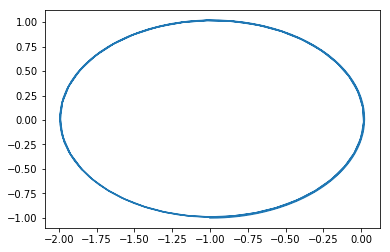

In [160]:
sys = SecondUnicycle(dt = 0.03)
sys_name = 'Unicycle'

x0 = np.array([-1,-1,0, 0, 0])
T = 200
u = np.ones((T, sys.Dx))

sys.set_init_state(x0)
sys.compute_matrices(x0,u[0])
xs = sys.rollout(u)
x_ref = np.array([2,2,0,0,0]) #for 2nd order unicycle
plt.plot(xs[:,0], xs[:,1])

#### Creating a Pendulum

In [146]:
sys = Pendulum(dt = 0.05)
sys_name = 'Inverted_Pendulum'
sys.b = 0.01
x0 = np.array([4*np.pi/4, 0])
sys.set_init_state(x0)

T = 200
us = np.zeros((T,sys.Du))
xs = sys.rollout(us)
x_ref = np.array([0,0]) #for pendulum
#sys.plot_traj(xs, dt = 0.01)

#### Creating a Bicopter 

In [169]:
sys = Bicopter(dt = 0.05)
sys_name = 'Bicopter'
x0 = np.zeros(6)
sys.set_init_state(x0)
T = 100
us = np.ones((T, sys.Du))*20
us[:,0] *= 2
xs = sys.rollout(us)
_ = sys.compute_matrices(x0, us[0])
x_ref = np.array([2,2,0,0,0,0]) #for bicopter

##  Using Class

#### Define cost parameters 

In [170]:
if sys_name == 'Bicopter':
    Q = np.eye(sys.Dx)*0.1
    #Q[1,1] *= 10
    #Q[3:,3:] = 0*Q[3:,3:] 
    Qf = np.eye(sys.Dx)*100
    #Qf[1,1] *= 10
    #Qf[3:,3:] = 0*Qf[3:,3:] 
    R = np.eye(sys.Du)*.1
elif sys_name == 'Inverted_Pendulum':
    Q = np.eye(sys.Dx)*0.1
    Q[1,1] *= 1
    #Q[3:,3:] = 0*Q[3:,3:] 
    Qf = np.eye(sys.Dx)*300
    #Qf[1,1] *= 10
    #Qf[3:,3:] = 0*Qf[3:,3:] 
    R = np.eye(sys.Du)*.3
elif sys_name == 'Unicycle':
    Q = np.eye(sys.Dx)*0.1
    #Q[1,1] *= 10
    #Q[3:,3:] = 0*Q[3:,3:] 
    Qf = np.eye(sys.Dx)*300
    #Qf[1,1] *= 10
    #Qf[3:,3:] = 0*Qf[3:,3:] 
    R = np.eye(sys.Du)*.1
    
    
    
mu = 1e-6

In [171]:
ilqr = ILQR_Standard(sys)
ilqr.set_init_state(x0)
ilqr.set_timestep(T)
ilqr.set_cost(Q,R,Qf)
ilqr.set_ref(np.zeros((T+1,sys.Dx)))

In [172]:
if sys_name == 'Bicopter':
    x_ref = np.array([2,2,0,0,0,0]) #for bicopter
elif sys_name == 'Inverted_Pendulum':
    x_ref = np.array([0,0]) #for pendulum
elif sys_name == 'Unicycle':
    x_ref = np.array([2,2,-np.pi/2,0,0]) #for 2nd order unicycle
    #x_ref = np.array([2,2,0]) #for 1st order unicycle
x_refs = np.array([x_ref]*(ilqr.T +1))

In [173]:
ilqr.set_ref(x_refs)

In [174]:
us = np.zeros((T+1,sys.Du))
sys.set_init_state(x0)
xs = sys.rollout(us[:-1])
ilqr.set_state(xs,us)

Text(0.5,1,'Bicopter')

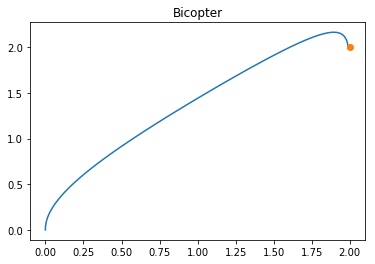

In [175]:
ilqr.solve(50)
clear_output()
#plt.plot(ilqr.xs[:,1], '-')
plt.plot(ilqr.xs[:,0],ilqr.xs[:,1], '-')
plt.plot(x_ref[0], x_ref[1], 'o')
plt.title(sys_name)

#### Use Least Square to compute the distribution

In [176]:
n_samples = 300
_ = ilqr.compute_du_LS()
sample_dxs, sample_dus = ilqr.sample_du(n_samples)
sample_dxs = np.array(sample_dxs).reshape(n_samples, T+1, -1)

sampling


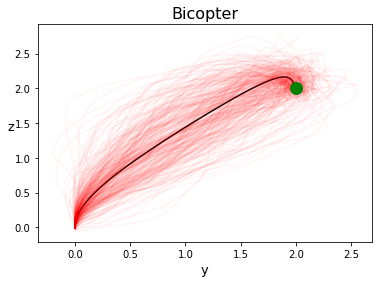

In [177]:
dim = [0,1]
plt.plot(ilqr.xs[:,dim[0]], ilqr.xs[:,dim[1]], 'k')
for i in range(n_samples):
    plt.plot(ilqr.xs[:,dim[0]] + sample_dxs[i,:,dim[0]], ilqr.xs[:,dim[1]]+ sample_dxs[i,:,dim[1]], 'r-', alpha=0.04 )
    #plt.plot(sample_xs[i,-1,0], 'o', alpha=0.3 )
    
plt.plot(x_ref[dim[0]], x_ref[dim[1]], 'go', markersize=12, label = 'Goal')
#plt.title('Trajectory Distribution of Bicopter', fontsize = 16)
plt.xlabel('y', fontsize = 13)
h = plt.ylabel('z', fontsize = 13)
h.set_rotation(0)
if sys_name == 'Inverted_Pendulum':
    plt.xlabel(r'$\theta$', fontsize = 13)
    h = plt.ylabel(r'$\dot \theta$', fontsize = 13)
    h.set_rotation(0)
    
plt.title(sys_name, fontsize = 16)
plt.savefig('temp/' + sys_name + '_dist.png', dpi=500)